# Detector & image2+3 reduction of NIRISS direct images

This notebook demonstrates how to reduce JWST data
This is the second of series of notebooks that focus on crwoded field photometry (see other notebooks in the directory).

This notebook will demonstrate how to reduce NIRISS WFSS and direct image data simulated in the previous step (1a&1b). Raw data (_uncal.fits) should be in the output directory.


## To Do:
- Run JWST reduction.


### Requirement:
- JWST pipeline environment. [see here](https://jwst-pipeline.readthedocs.io/en/latest/)


### This notebook can also be used for NIRCam images with minimal update. 

In [1]:
import glob
import os
import argparse
from astropy.io import fits
try:
    from configobj import ConfigObj
except ModuleNotFoundError:
    from jwst.extern.configobj.configobj import ConfigObj

from jwst.pipeline import collect_pipeline_cfgs
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Image3Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

import yaml

In [2]:
# Some fancy function;
TERM = os.get_terminal_size()
SYM = "~"
def printnice(level):
    """
    Print the current pipeline level and make it nice :)
    Args:
        level (str): The thing you want to print nicely.
    """

    print("\n", SYM*TERM.columns, "\n", SYM, level.center(TERM.columns-2), SYM, "\n", SYM*TERM.columns, "\n", sep="")

In [3]:
### Let's make a reduction directory, to avoid too many items.
DIR_RED = './reduction/'
if not os.path.exists(DIR_RED):
    os.mkdir(DIR_RED)


#### Collect niriss raw images;
You can use real images from JWST or simulated images from Mirage.

Here I'm using images simulated in example Notebook a1/a2, which locate in DIR_FILE directory.

In [4]:
DIR_FILE = './output/'
images  = glob.glob('%s*_nis_uncal.fits'%(DIR_FILE))
images

['./output/jw00042001001_01101_00010_nis_uncal.fits',
 './output/jw00042001001_01101_00006_nis_uncal.fits',
 './output/jw00042001001_01101_00001_nis_uncal.fits',
 './output/jw00042001001_01101_00003_nis_uncal.fits',
 './output/jw00042001001_01101_00009_nis_uncal.fits',
 './output/jw00042001001_01101_00012_nis_uncal.fits',
 './output/jw00042001001_01101_00011_nis_uncal.fits',
 './output/jw00042001001_01101_00002_nis_uncal.fits',
 './output/jw00042001001_01101_00004_nis_uncal.fits',
 './output/jw00042001001_01101_00007_nis_uncal.fits',
 './output/jw00042001001_01101_00005_nis_uncal.fits',
 './output/jw00042001001_01101_00008_nis_uncal.fits']

#### Setup output & Configuration paths;

In [5]:
configdir = './%s/conf/'%DIR_RED # Where configuration files for Webb pipeline locate.
outdir    = './%s/output_nis/'%DIR_RED # Where your reduced products will locate.

In [6]:
if configdir is None:
    print("Downloading config files to current directory")
    collect_pipeline_cfgs.collect_pipeline_cfgs()
    configdir = "."
if outdir is None:
    outdir = os.path.dirname(image)
if not os.path.exists(outdir):
    os.mkdir(outdir)
    print("Created directory {}".format(outdir))

# Ensure that the source_catalog step has save_results set to True
sc = ConfigObj(os.path.join(configdir, "source_catalog.cfg"))
if "save_results" not in sc:
    print("Modifying {} to add save_results option".format(os.path.join(configdir, "source_catalog.cfg")))
    sc["save_results"] = True
    sc.write()

### Start reduction --- DETECTOR1 and IMAGE2. 
#### For this part, it does not matter if you provide NIRISS or NIRCam images.

In [14]:
image2_files = []
for image in images:
    # Run both the direct and dispersed images through Detector11.
    #printnice("DETECTOR1")
    image1 = Detector1Pipeline.call(image, save_results=True,
                config_file=os.path.join(configdir, "calwebb_detector1.cfg"),
                output_dir=outdir)
    image1_file = os.path.join(outdir, image1.meta.filename)

    # Run the image through Image2.
    printnice("IMAGE2")
    image2 = Image2Pipeline.call(image1_file, save_results=True,
                config_file=os.path.join(configdir, "calwebb_image2.cfg"),
                output_dir=outdir)
    image2_file = os.path.join(outdir, image2[0].meta.filename)
    image2_files.append(image2_file)
    

'    image1 = Detector1Pipeline.call(image, save_results=True,\n                config_file=os.path.join(configdir, "calwebb_detector1.cfg"),\n                output_dir=outdir)\n    image1_file = os.path.join(outdir, image1.meta.filename)\n\n    # Run the image through Image2.\n    printnice("IMAGE2")\n    image2 = Image2Pipeline.call(image1_file, save_results=True,\n                config_file=os.path.join(configdir, "calwebb_image2.cfg"),\n                output_dir=outdir)\n    image2_file = os.path.join(outdir, image2[0].meta.filename)\n    image2_files.append(image2_file)'

### You should find reduced files in outdir, including _nis_cal.fits (calibrated image2 products).
These files will be used in IMAGE3 reduction, to get a final stacked image.

In [19]:
# Example;

# 1. Create json file
product_name = 'l3_nis_f200w'
json_name    = 'l3_asn_nis_f200w.json'
line = 'asn_from_list -o %s --product-name %s %s/jw00042001001_01101_000{01,06,07,12}_nis_cal.fits'%(json_name,product_name,outdir)
# Execute 'line' in command line tool.
os.system(line)

In [20]:
# 2. Run image3 reduction with the json file above;
line = 'strun %s/calwebb_image3.cfg %s'%(configdir,json_name)
os.system(line)

### You will get [product_name]_i2d.fits, which is a stacked (and drizzled) image.

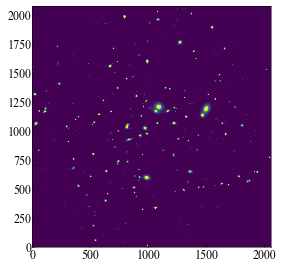

In [22]:
from astropy.io import fits
import matplotlib.pyplot as plt
image3 = '%s_i2d.fits'%(product_name)
data   = fits.open(image3)[1].data
plt.imshow(data,vmin=0,vmax=1.)

### Tips:
If your images are not alinged, you may want to change Tweakreg parameters in conf/Tweakreg.cfg for better alignment.

Also, other parameters can be tweaked from the configuration files there.